# Primera versión y analisis del pipeline

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 7]

In [ ]:
# leemos las imagenes
imagenes = [ cv2.imread('Imagenes/Intestino curso/02.tif'),
           cv2.imread('Imagenes/Intestino curso/03.tif')]

In [ ]:
plt.axis('off')
plt.imshow(imagenes[0])

In [ ]:
plt.axis('off')
plt.imshow(imagenes[1])

In [ ]:
# elegimos un descriptor
# alternativamente cv2.xfeatures2d.SURF_create()
descriptor = cv2.SIFT_create()

# caracterizamos las imagenes
keypoints = []
features = []
for imagen in imagenes:
    # paso opcional... pasar imagen a blanco y negro
    # en fotografias normales se suele hacer
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # aca opcionalmente podriamos agregar la mascara marcando el borde donde se encuentra
    # la superposicion con la otra imagen
    (kps, feat) = descriptor.detectAndCompute(gray, mask=None)
    keypoints.append(kps)
    features.append(feat)

In [ ]:
# elegimos un ratio arbitrario para test de Lowe
ratio = 0.75

In [ ]:
# para matchear entre los features utilizamos kNN para obtener los dos
# features mas parecidos
matcher = cv2.DescriptorMatcher_create("BruteForce")
rawMatches = matcher.knnMatch(features[0],
                              features[1],
                              2)

# aplicamos es test de Lowe para determinar que macheos son buenos
matches = []
for (m1, m2) in rawMatches:
    #  Lowe's ratio test
    if m1.distance < m2.distance * ratio:
        matches.append((m1.trainIdx, m1.queryIdx))

Ya tenemos los macheos, en la celda de abajo los podemos plotear

In [ ]:

matchesMask = [[0,0] for i in range(len(rawMatches))]
imagen1Matcheos = imagenes[0].copy()
imagen2Matcheos = imagenes[1].copy()
for i, (m1,m2) in enumerate(rawMatches):
    if m1.distance < ratio * m2.distance:
        matchesMask[i] = [1,0]
        pt1 = keypoints[0][m1.queryIdx].pt
        pt2 = keypoints[1][m1.trainIdx].pt
        cv2.circle(imagen1Matcheos, (int(pt1[0]),int(pt1[1])), 10, (255,0,255), -1)
        cv2.circle(imagen2Matcheos, (int(pt2[0]),int(pt2[1])), 10, (255,0,255), -1)


## Draw match in blue, error in red
draw_params = dict(matchColor = (255, 0,0),
                   singlePointColor = (0,0,255),
                   matchesMask = matchesMask,
                   flags = 0)

res = cv2.drawMatchesKnn(imagen1Matcheos,
                         keypoints[0],
                         imagen2Matcheos,
                         keypoints[1],
                         rawMatches,
                         None,
                         **draw_params)

plt.rcParams['figure.figsize'] = [20, 15]
plt.imshow(res)

Podemos ver que hay muchos features en cada imagen (puntos azules chicos), y los macheos no son tantos, con la gran mayoria en el borde que queremos. Igual se puede ver que hay varios falsos positivos. Esperamos que estos sean descartados como outliers cuando busquemos matriz homográfica.

In [ ]:
toleranciaRansac = 4

In [ ]:
# calculamos matriz homográfica
# para ello necesitamos al menos 4 macheos, ya que 
# el algoritmo la computa resolviendo un sistema de ecuaciones

keypointsAFloat = [np.float32([kp.pt for kp in kps]) for kps in keypoints]

if len(matches) > 4:
    ptsA = np.float32([keypointsAFloat[0][i] for (_, i) in matches])
    ptsB = np.float32([keypointsAFloat[1][i] for (i, _) in matches])
    (H, inliners) = cv2.findHomography(
        ptsB, ptsA, cv2.RANSAC, toleranciaRansac)
else:
    print("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")

Visualizamos en la proxima celda los inliners que quedaron contemplados por la matriz homografica.

In [ ]:
matchesMask = [[0,0] for i in range(len(rawMatches))]
imagen1Matcheos = imagenes[0].copy()
imagen2Matcheos = imagenes[1].copy()
j = 0
for i, (m1,m2) in enumerate(rawMatches):
    if m1.distance < ratio * m2.distance:
        if inliners[j] == 1:
            matchesMask[i] = [1,0]
        pt1 = keypoints[0][m1.queryIdx].pt
        pt2 = keypoints[1][m1.trainIdx].pt
        cv2.circle(imagen1Matcheos, (int(pt1[0]),int(pt1[1])), 10, (255,0,255), -1)
        cv2.circle(imagen2Matcheos, (int(pt2[0]),int(pt2[1])), 10, (255,0,255), -1)
        j+=1


## Draw match in blue, error in red
draw_params = dict(matchColor = (255, 0,0),
                   singlePointColor = (0,0,255),
                   matchesMask = matchesMask,
                   flags = 0)

res = cv2.drawMatchesKnn(imagen1Matcheos,
                         keypoints[0],
                         imagen2Matcheos,
                         keypoints[1],
                         rawMatches,
                         None,
                         **draw_params)

plt.imshow(res)

Se puede ver que si cambiamos la tolerancia del Ransac cambia la cantidad de inliners.

In [ ]:
hasta = 30
ys = []
for tolerancia in np.arange(0,hasta,1):
    (H, inliners) = cv2.findHomography(
        ptsB, ptsA, cv2.RANSAC, tolerancia, )
    ys.append(sum(inliners))

plt.rcParams['figure.figsize'] = [10, 7]
plt.figure(0)
plt.plot(np.arange(0,hasta,1), ys, marker='o', color='blue', label="inliners")
plt.plot([-10,hasta+10], [len(matches), len(matches)], color='red', alpha=0.7,linestyle='--', label="cant. matches")
plt.ylabel("Cant. inliners")
plt.ylim([0, len(matches)+10])
plt.xlim([-0.9, hasta])
plt.xlabel("Tolerancia")
plt.legend()
plt.show()


Ahora que tenemos la matriz homografica podemos realizar el pegado. El pegado más básico, warpea la segunda imagen en base a la transformación que encontramos, y pega la primer imagen tal como vino.

In [ ]:
result = cv2.warpPerspective(imagenes[1], H,
      (imagenes[1].shape[1] + imagenes[0].shape[1], imagenes[1].shape[0]))
result[0:imagenes[0].shape[0], 0:imagenes[0].shape[1]] = imagenes[0]
plt.rcParams['figure.figsize'] = [20, 15]
plt.imshow(result)

# Segunda version un poco más robusta

Comienzo definiendo una clase para las imagenes, para poder abstraer un poco el proceso de pegado, descripción y transformación de las mismas. El pipeline del stitch sigue siendo el mismo igual.
Por otro lado el proceso de pegado es más general y se banca pegar una imagen arriba de la otra, o en orden invertido.

In [ ]:
class Imagen:
    def __init__(self, image, descriptor, canalAlpha=True, alpha=255):
        self.imagen = image
        if canalAlpha:
            self.agregarCanalAlpha(alpha)

        self._keypoints = None
        self._features = None
        self._posicion = (0, 0)
        self._esquinas = np.array([
            [0, 0, 1],
            [self.imagen.shape[1], 0, 1],
            [0, self.imagen.shape[0], 1],
            [self.imagen.shape[1], self.imagen.shape[0], 1]
        ])

        self.descriptor = descriptor
        self._descripta = False

    @property
    def keypoints(self):
        if self._descripta:
            return np.float32([kp.pt for kp in self._keypoints])
        else:
            self.detectarYDescribir(None)
            return np.float32([kp.pt for kp in self._keypoints])

    @property
    def features(self):
        if self._descripta:
            return self._features
        else:
            self.detectarYDescribir(None)
            return self._features
    
    def getKeypoints(self, mascara=None):
        self.detectarYDescribir( mascara )
        return np.float32([kp.pt for kp in self._keypoints])

    def getFeatures(self, mascara=None):
        self.detectarYDescribir( mascara )
        return self._features

    @property
    def esquinas(self):
        return np.round(self._esquinas[:, 0:2])

    @property
    def posicion(self):
        return self._posicion

    @property
    def shape(self):
        return self.imagen.shape

    def detectarYDescribir(self, mascara):
        gray = cv2.cvtColor(self.imagen, cv2.COLOR_BGR2GRAY)
        
        (kps, features) = self.descriptor.detectAndCompute(gray, mask=mascara)

        self._keypoints = kps
        self._features = features
        self._descripta = True

    def transformar(self, matrizHomografica, limite=None):
        esquinasViejas = self._esquinas
        self._esquinas = (np.dot(matrizHomografica, self._esquinas.T)).T
        self._esquinas = np.array([ esquina / esquina[2] for esquina in self._esquinas ])

        smallestX = np.min([esquina[0] for esquina in self._esquinas])
        biggestX = np.max([esquina[0] for esquina in self._esquinas])
        smallestY = np.min([esquina[1] for esquina in self._esquinas])
        biggestY = np.max([esquina[1] for esquina in self._esquinas])

        nuevaShape = (
            int(np.floor(biggestY - smallestY)),
            int(np.floor(biggestX - smallestX))
        )
    
        # hay veces que las transformaciones son cualquier cosa, y arman imagenes enormes, todo crashea, un caos.
        # sabemos que las imagenes son mas o menos homogeneas, y que el tamano despues de la transformacion
        # no puede exceder cierto limite. aca lo chequeo y levanto una excepcion
        if not limite is None and (limite * self.shape[0] < nuevaShape[0] or limite * self.shape[1] < nuevaShape[1]):
            self._esquinas = esquinasViejas
            raise Exception("La transformacion excede limite de tamano")

        # corrijo para que quede en 0,0
        traslacion = np.array([
            [1, 0, -smallestX],
            [0, 1, -smallestY],
            [0, 0, 1]
        ])
        nuevaHomografica = np.matmul(traslacion, matrizHomografica)

        self.imagen = cv2.warpPerspective(self.imagen, nuevaHomografica, (
            nuevaShape[1], nuevaShape[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(125, 125, 125, 0))

        self._posicion = [0 if smallestX < 0 else int(
            np.round(smallestX)), 0 if smallestY < 0 else int(np.round(smallestY))]

        self._describida = False

    def mover(self, x, y):
        self._posicion = (x, y)

    def agregarCanalAlpha(self, value):
        if self.imagen.shape[2] < 4:
            b_channel, g_channel, r_channel = cv2.split(self.imagen)
            alpha_channel = np.ones(
                b_channel.shape, dtype=b_channel.dtype) * value
            self.imagen = cv2.merge(
                (b_channel, g_channel, r_channel, alpha_channel))

    def pegar(self, imagenAPegar):
        if imagenAPegar.posicion[0] > self.imagen.shape[1] or imagenAPegar.posicion[1] > self.imagen.shape[0]:
            return

        else:
            h, w = imagenAPegar.shape[0], imagenAPegar.shape[1]
            (x, y) = imagenAPegar.posicion
            if x+w > self.imagen.shape[1] or y+h > self.imagen.shape[0]:
                raise Exception("La imagen a pegar supera el tamaño del fondo")

            overlay_image = imagenAPegar.imagen
            mask = imagenAPegar.imagen[..., 3:] / 255.0
            self.imagen[y:y+h, x:x+w] = (1.0 - mask) * \
                self.imagen[y:y+h, x:x+w] + mask * overlay_image

Entonces así nos quedaría el pipeline para pegar dos imagenes de nuestra clase:

In [ ]:
# esta funcion matchea entre los features de dos imagenes y calcula la matriz homografica
def matchearImagenes(imagenA, imagenB, ratio, tolerancia):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(imagenB.features, imagenA.features, 2)
    matches = []

    for m in rawMatches:
        #  Lowe's ratio test
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    if len(matches) > 4:
        ptsA = np.float32([imagenA.keypoints[i] for (i, _) in matches])
        ptsB = np.float32([imagenB.keypoints[i] for (_, i) in matches])
        (H, inliners) = cv2.findHomography( ptsB, ptsA, cv2.RANSAC, tolerancia)

        if H is None:
            raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        return (matches, H, inliners)
    else:
        raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")

Esta funcion realiza todo el pipeline para un par de imagenes. La logica agregada, lo unico que hace es croppear la imagen resultado para quedarnos solo con la zona de interes, es decir el min rectangulo que contemple ambas imagenes. Otra cosa es la decision de pegar la imagen B (la transformada) sobre la imagen A. Esto se puede hacer al revez, es lo mismo.

In [ ]:
def stitchPar(imagenA, imagenB, ratio, tolerancia):
    (matches, H, inliners) = matchearImagenes(imagenA, imagenB, ratio, tolerancia)
    imagenB.transformar(H)

    imagenA.mover(int(np.abs(np.clip(np.min([esquina[0] for esquina in imagenB.esquinas]), None, 0))),
                  int(np.abs(np.clip(np.min([esquina[1] for esquina in imagenB.esquinas]), None, 0))))

    smallestX = np.min([imagenB.posicion[0], imagenA.posicion[0]])
    biggestX = np.max([imagenB.posicion[0] + imagenB.shape[1],
                      imagenA.posicion[0] + imagenA.shape[1]])
    smallestY = np.min([imagenB.posicion[1], imagenA.posicion[1]])
    biggestY = np.max([imagenB.posicion[1] + imagenB.shape[0],
                      imagenA.posicion[1] + imagenA.shape[0]])

    resultShape = (
        int(np.floor(biggestY - smallestY)),
        int(np.floor(biggestX - smallestX)),
        4
    )
    result = Imagen(np.zeros(resultShape, np.uint8), imagenA.descriptor )

    result.pegar(imagenA)
    result.pegar(imagenB)

    return result

De esta forma, para pegar muchas imagenes (primero por columnas y luego por filas) es relativamente sencillo

In [ ]:
def stitch( imagenes, grilla , orden ):
    indice = 0
    panorama = None
    for fila in range(grilla[0]):
        imagenFila = imagenes[orden[indice] - 1]
        for col in range(grilla[1] - 1):
            imagenFila = stitchPar( imagenFila, imagenes[orden[indice + 1] - 1], ratio, tolerancia )
            indice += 1
        indice += 1
        panorama = imagenFila if panorama is None else stitchPar( panorama, imagenFila, ratio, tolerancia)

    return panorama.imagen

In [ ]:
descriptor = cv2.SIFT_create()
grilla = (1,3)
orden = [1,2,3]

# leemos las imagenes
imagenes = [ Imagen( cv2.imread('Imagenes/Intestino curso/01.tif'), descriptor ),
             Imagen( cv2.imread('Imagenes/Intestino curso/02.tif'), descriptor ),
             Imagen( cv2.imread('Imagenes/Intestino curso/03.tif'), descriptor )]

plt.imshow(stitch(imagenes, grilla, orden))

# Ejemplos que NO andan :|

Con tres imagenes andaba regio.. pero cuando queremos pegar la 4ta, explota porque no encuentra suficientes matcheos.

In [ ]:
descriptor = cv2.SIFT_create()
grilla = (1,4)
orden = [1,2,3,4]

# leemos las imagenes
imagenes = [ Imagen( cv2.imread('Imagenes/Intestino curso/01.tif'), descriptor ),
             Imagen( cv2.imread('Imagenes/Intestino curso/02.tif'), descriptor ),
             Imagen( cv2.imread('Imagenes/Intestino curso/03.tif'), descriptor ),
             Imagen( cv2.imread('Imagenes/Intestino curso/04.tif'), descriptor )]

plt.imshow(stitch(imagenes, grilla, orden))

Las imagenes son estas:

In [ ]:
descriptor = cv2.SIFT_create()
descriptor = cv2.xfeatures2d.SURF_create()
imagenA = Imagen(cv2.imread('Imagenes/Intestino curso/03.tif'), descriptor)
imagenB = Imagen(cv2.imread('Imagenes/Intestino curso/04.tif'), descriptor)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]
plt.imshow(imagenA.imagen)

In [ ]:
plt.imshow(imagenB.imagen)

Los matcheos:

In [ ]:
matcher = cv2.DescriptorMatcher_create("BruteForce")
rawMatches = matcher.knnMatch(imagenA.features,
                              imagenB.features,
                              2)

matchesMask = [[0,0] for i in range(len(rawMatches))]
imagen1Matcheos = imagenA.imagen.copy()
imagen2Matcheos = imagenB.imagen.copy()
cantidadMatcheos = 0
for i, (m1,m2) in enumerate(rawMatches):
    if m1.distance < ratio * m2.distance:
        cantidadMatcheos += 1
        matchesMask[i] = [1,0]
        pt1 = imagenA.keypoints[m1.queryIdx]
        pt2 = imagenB.keypoints[m1.trainIdx]
        cv2.circle(imagen1Matcheos, (int(pt1[0]),int(pt1[1])), 10, (255,0,255), -1)
        cv2.circle(imagen2Matcheos, (int(pt2[0]),int(pt2[1])), 10, (255,0,255), -1)


## Draw match in blue, error in red
draw_params = dict(matchColor = (255, 0,0),
                   singlePointColor = (0,0,255),
                   matchesMask = matchesMask,
                   flags = 0)

res = cv2.drawMatchesKnn(imagen1Matcheos,
                         imagenA._keypoints,
                         imagen2Matcheos,
                         imagenB._keypoints,
                         rawMatches,
                         None,
                         **draw_params)

plt.rcParams['figure.figsize'] = [20, 15]
plt.imshow(res)
print("Cantidad de matcheos: ", cantidadMatcheos)

En este plot queda bien claro que la mayoria de los matcheos son falsos positivos. Además de los pocos que son.

Si volvemos a correr la celda donde elegimos el descriptor y lo cambiamos por SURF, tenemos muchisimos más matcheos. Sin embargo la cantidad de falsos positivos siguen siendo muy altos.

Un problema muy evidente es que está matcheando features en lugares donde sabemos de antemano que no hay superposición. Deberíamos agregar mascaras a la hora de realizar el matcheo.

Definimos una función para crear mascaras

In [ ]:
# eje marca si de izq a der o arriba a abajo
# orden si a izq o a der (o arr o abajo)
def crearMascara( shape, proporcion, eje=0, orden=0 ):
    if eje == 0:
        anchoMascara = int( shape[1] * proporcion )
        izq = np.zeros( (shape[0],shape[1] - anchoMascara, 1), dtype=np.uint8 )
        der = np.ones( (shape[0], anchoMascara, 1), dtype=np.int8 ) * 255
        return np.hstack( (izq,der) ).astype(np.uint8) if orden == 0 else np.hstack( (der,izq) ).astype(np.uint8)
    else:
        altoMascara = int( shape[0] * proporcion )
        arr = np.zeros( (shape[0] - altoMascara, shape[1], 1), dtype=np.uint8 )
        aba = np.ones( (altoMascara, shape[1], 1), dtype=np.int8 ) * 255
        return np.vstack( (arr,aba) ).astype(np.uint8) if orden == 0 else np.vstack( (aba,arr) ).astype(np.uint8)


In [ ]:
def dibujarMatcheos( imagenA, imagenB, mascaras ):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    rawMatches = matcher.knnMatch(imagenA.getFeatures( mascaras[0] ),
                                  imagenB.getFeatures( mascaras[1] ),
                                  2)

    matchesMask = [[0,0] for i in range(len(rawMatches))]
    imagen1Matcheos = imagenA.imagen.copy()
    imagen2Matcheos = imagenB.imagen.copy()
    for i, (m1,m2) in enumerate(rawMatches):
        if m1.distance < ratio * m2.distance:
            matchesMask[i] = [1,0]
            pt1 = imagenA.keypoints[m1.queryIdx]
            pt2 = imagenB.keypoints[m1.trainIdx]
            cv2.circle(imagen1Matcheos, (int(pt1[0]),int(pt1[1])), 10, (255,0,255), -1)
            cv2.circle(imagen2Matcheos, (int(pt2[0]),int(pt2[1])), 10, (255,0,255), -1)


    ## Draw match in blue, error in red
    draw_params = dict(matchColor = (255, 0,0),
                       singlePointColor = (0,0,255),
                       matchesMask = matchesMask,
                       flags = 0)

    res = cv2.drawMatchesKnn(imagen1Matcheos,
                             imagenA._keypoints,
                             imagen2Matcheos,
                             imagenB._keypoints,
                             rawMatches,
                             None,
                             **draw_params)
    return res

In [ ]:
plt.rcParams['figure.figsize'] = [20, 15]
plt.imshow(dibujarMatcheos(imagenA, imagenB, crearMascara(imagenA.shape, 0.3), crearMascara(imagenB.shape, 0.3, orden=1)))

Usando SURF y mascaras entonces nos queda un matcheo mucho más prometedor. Faltaría entonces agregar mascaras a nuestro pipeline.

# Version 3:

In [15]:
def matchearImagenes(imagenA, imagenB, ratio, tolerancia, mascaras=None):
    matcher = cv2.DescriptorMatcher_create("BruteForce")
    if mascaras is None:
        rawMatches = matcher.knnMatch(imagenB.features, imagenA.features, 2)
    else:
        rawMatches = matcher.knnMatch(imagenB.getFeatures(mascaras[1]), imagenA.getFeatures(mascaras[0]), 2)
    matches = []

    for m in rawMatches:
        #  Lowe's ratio test
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))

    if len(matches) > 4:
        ptsA = np.float32([imagenA.keypoints[i] for (i, _) in matches])
        ptsB = np.float32([imagenB.keypoints[i] for (_, i) in matches])
        (H, inliners) = cv2.findHomography( ptsB, ptsA, cv2.RANSAC, tolerancia)

        if H is None:
            raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        return (matches, H, inliners)
    else:
        raise Exception("No hubo suficientes coincidencias entre las caracteristicas de las imagenes")
        
def stitchPar(imagenA, imagenB, ratio, tolerancia, mascaras=None, limite=None):
    (matches, H, inliners) = matchearImagenes(imagenA, imagenB, ratio, tolerancia, mascaras)
    
    imagenB.transformar(H, limite)  

    imagenA.mover(int(np.abs(np.clip(np.min([esquina[0] for esquina in imagenB.esquinas]), None, 0))),
                  int(np.abs(np.clip(np.min([esquina[1] for esquina in imagenB.esquinas]), None, 0))))

    smallestX = np.min([imagenB.posicion[0], imagenA.posicion[0]])
    biggestX = np.max([imagenB.posicion[0] + imagenB.shape[1],
                      imagenA.posicion[0] + imagenA.shape[1]])
    smallestY = np.min([imagenB.posicion[1], imagenA.posicion[1]])
    biggestY = np.max([imagenB.posicion[1] + imagenB.shape[0],
                      imagenA.posicion[1] + imagenA.shape[0]])

    resultShape = (
        int(np.floor(biggestY - smallestY)),
        int(np.floor(biggestX - smallestX)),
        4
    )
    result = Imagen(np.zeros(resultShape, np.uint8), imagenA.descriptor )

    result.pegar(imagenA)
    result.pegar(imagenB)

    return result

def stitch( imagenes, grilla , orden ):
    indice = 0
    panorama = None
    for fila in range(grilla[0]):
        imagenFila = imagenes[orden[indice] - 1]
        for col in range(grilla[1] - 1):
            proporcionMascaras = np.array([(1/ (col+1)) / 2, 0.5])
            
            while True:
                mascaras = (
                            # esto hay que hacerlo mejor, calculando que proporcion de la fila ocupa la 
                            # ultima imagen pegada
                            crearMascara(imagenFila.shape, proporcionMascaras[0] ),
                            crearMascara(imagenes[orden[indice + 1] - 1].shape, proporcionMascaras[1], orden=1)
                )
                try:
                    imagenFila = stitchPar( imagenFila, imagenes[orden[indice + 1] - 1], ratio, tolerancia, mascaras, limite=2 )
                    break
                except Exception as e:
                    if proporcionMascaras[0] < 0.001 or proporcionMascaras[1] < 0.01:
                        raise Exception("No se pudo realizar el pegado")
                    else:
                        proporcionMascaras /= 1.3
                    
                
            indice += 1
        indice += 1
        panorama = imagenFila if panorama is None else stitchPar( panorama, imagenFila, ratio, tolerancia)

    return panorama.imagen

El while basicamente lo agregue como un hack medio trucho. Si la transformación que encuentra sabemos que no anda porque la imagen transformada superaría un tamaño aceptable, volvemos a probar con máscaras cada vez más agresivas hasta cierto limite, donde si todavía la transformación sigue siendo muy mala nos damos por vencidos.

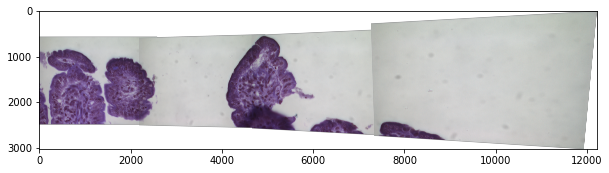

In [16]:
descriptor = cv2.xfeatures2d.SURF_create()
grilla = (1,4)
orden = [1,2,3,4]

ratio = 0.75
tolerancia = 4

# leemos las imagenes
imagenes = [ Imagen( cv2.imread('Imagenes/Intestino curso/01.tif'), descriptor ),
             Imagen( cv2.imread('Imagenes/Intestino curso/02.tif'), descriptor ),
             Imagen( cv2.imread('Imagenes/Intestino curso/03.tif'), descriptor ),
             Imagen( cv2.imread('Imagenes/Intestino curso/04.tif'), descriptor )]

resultado = stitch(imagenes, grilla, orden)
plt.imshow(resultado)

Se pegó más o menos bien... me parece que al tener pocos matcheos, y que están muy sobre un borde, la matriz homográfica que encuentra transforma de formas un poco desproporcionadas al resto de la imagen. Tal vez se podría buscar una matriz homográfica que no solo matchee la mayor cantidad de features posibles, sino que tambien mantenga el aspecto cuadrado de la imagen. Ya que sabemos que como fueron tomadas por un microscopio, no van a tener deformaciones por lentes o cosas por el estilo, más comunes en fotografía.